### Working on the Thrash dataset

Needs to be done:
1. Loading the data from dataset
    1. Looking at the data and see what the dimensionality is and the quality.
2. Transforming the data to make it better for ML methods
    1. Standardscaler?
    2. Only a black and white set? (To reduce the size of the model and inputs as it would be in continues operations)
    3. Only a black/white and Green set?
3. Training using the FFNN in project 2
    1. Write the results and how we apply them here to find the optimal parameters for our model
4. Using the CNN architecture to see if it have better performance
5. Analytical Analysis of the results, looking at the wrong errors and see if it is good.
6. Comparing these results with the once in MNIST for project 2 and see if they are good.
7. Comparing these results with the research paper that utilized this dataset and other thrash spotting models.
8. Perhaps this should instead be using the 


- Perhaps using a pretrained model than train that one on the specific usecase would be better. Usage of Laura? method where one downscales the models to minimize the inference cost and have a more dense model specilaised to the specific problem.


### Cleaning the data

In [ ]:
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
data_dir = r'.\realwaste-main\RealWaste'
def load_realwaste_dataset(data_dir, img_size=(128, 128), test_size=0.2, random_state=42, grayscale=False,drop=[None]):
    """
    Load RealWaste dataset with stratified train-test split.
    
    Parameters:
    -----------
    data_dir : str
        Path to the RealWaste directory containing category folders
    img_size : tuple
        Target size for images (height, width)
    test_size : float
        Proportion of dataset to include in test split (default: 0.2)
    random_state : int
        Random seed for reproducibility
    grayscale : bool
        If True, convert images to grayscale (default: False for RGB)
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : numpy arrays
        Training and test sets
    class_names : list
        List of class names corresponding to label indices
    """
    
    # Define the class folders
    class_folders = [
        'Cardboard', 'Food Organics', 'Glass', 'Metal', 
        'Miscellaneous Trash', 'Paper', 'Plastic', 
        'Textile Trash', 'Vegetation'
    ]
    
    if drop[0] is not None:
        class_folders = [cf for cf in class_folders if cf not in drop]
    
    images = []
    labels = []
    class_names = []
    
    print("Loading images from dataset...")
    for class_idx, class_name in enumerate(class_folders):
        class_path = Path(data_dir) / class_name
        if not class_path.exists():
            print(f"Warning: {class_name} folder not found at {class_path}")
            continue
            
        class_names.append(class_name)
        image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
        
        print(f"Loading {len(image_files)} images from {class_name}...")
        for img_path in image_files:
            try:
                # Load and resize image
                img = Image.open(img_path)
                
                # Convert to grayscale or RGB
                if grayscale:
                    img = img.convert('L')  # Grayscale
                else:
                    img = img.convert('RGB')  # RGB
                
                img = img.resize(img_size)
                
                # Convert to numpy array and normalize to [0, 1]
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"\nDataset loaded:")
    print(f"Total images: {len(X)}")
    print(f"Image shape: {X.shape[1:]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"\nClass distribution:")
    for idx, class_name in enumerate(class_names):
        count = np.sum(y == idx)
        print(f"  {class_name}: {count} images")
    
    # Stratified train-test split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nTrain set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")
    print(f"\nTrain set class distribution:")
    for idx, class_name in enumerate(class_names):
        count = np.sum(y_train == idx)
        print(f"  {class_name}: {count} images ({count/len(y_train)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test, class_names

### Load the Dataset

Now let's load the RealWaste dataset with stratified splitting:

In [ ]:
# Set the path to your RealWaste dataset
data_dir = "realwaste-main/RealWaste"

# Load the dataset (RGB version)
X_train, X_test, y_train, y_test, class_names = load_realwaste_dataset(
    data_dir=data_dir,
    img_size=(128, 128),  
    test_size=0.2,        
    random_state=42,
    grayscale=False       
)

print("\nDataset loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Loading images from dataset...
Loading 461 images from Cardboard...
Loading 411 images from Food Organics...
Loading 420 images from Glass...
Loading 790 images from Metal...
Loading 495 images from Miscellaneous Trash...
Loading 500 images from Paper...
Loading 921 images from Plastic...
Loading 318 images from Textile Trash...
Loading 436 images from Vegetation...

Dataset loaded:
Total images: 4752
Image shape: (128, 128, 3)
Number of classes: 9

Class distribution:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Train set: 3801 images
Test set: 951 images

Train set class distribution:
  Cardboard: 369 images (9.7%)
  Food Organics: 329 images (8.7%)
  Glass: 336 images (8.8%)
  Metal: 632 images (16.6%)
  Miscellaneous Trash: 396 images (10.4%)
  Paper: 400 images (10.5%)
  Plastic: 736 images (19.4%)
  Textil

## Creating more data to the dataset

In [9]:
import numpy as np

def augment_training_data(X_train, y_train):
    """
    Augments the training set by adding rotations and flips.
    
    Parameters:
    -----------
    X_train : numpy array
        Original training images (N, H, W, C) or (N, H, W)
    y_train : numpy array
        Original training labels (N,)
        
    Returns:
    --------
    X_aug, y_aug : numpy arrays
        The augmented training set containing original + new images
    """
    print("Starting data augmentation...")
    
    X_aug_list = [X_train]
    y_aug_list = [y_train]
    
    # 1. Flip Left-Right
    X_lr = np.flip(X_train, axis=2) # axis 2 is width
    X_aug_list.append(X_lr)
    y_aug_list.append(y_train)
    
    # 2. Flip Up-Down
    X_ud = np.flip(X_train, axis=1) # axis 1 is height
    X_aug_list.append(X_ud)
    y_aug_list.append(y_train)
    
    # 3. Rotate 90 degrees
    X_rot90 = np.rot90(X_train, k=1, axes=(1, 2)) 
    X_aug_list.append(X_rot90)
    y_aug_list.append(y_train)
    
    # 4. Rotate 180 degrees
    X_rot180 = np.rot90(X_train, k=2, axes=(1, 2))
    X_aug_list.append(X_rot180)
    y_aug_list.append(y_train)

    # 5. Rotate 270 degrees
    X_rot270 = np.rot90(X_train, k=3, axes=(1, 2))
    X_aug_list.append(X_rot270)
    y_aug_list.append(y_train)
    
    # Combine all lists
    X_aug = np.concatenate(X_aug_list, axis=0)
    y_aug = np.concatenate(y_aug_list, axis=0)
    
    # Shuffle the augmented data (optional but recommended)
    shuffle_indices = np.random.permutation(len(X_aug))
    X_aug = X_aug[shuffle_indices]
    y_aug = y_aug[shuffle_indices]
    
    print(f"Augmentation complete. Final training set size: {len(X_aug)}")
    return X_aug, y_aug

In [10]:
X_aug, y_aug = augment_training_data(X_train, y_train)

Starting data augmentation...
Augmentation complete. Final training set size: 22806


## Training on the FFNN implementation

### Training on FFNN from Project 2
Took to long but had the same results

In [11]:
import Functions as F

X_train_flat = X_train.reshape(X_train.shape[0], -1)
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))


best_score, best_iteration,best_model,training_scores,testing_scores = F.run_training_experiment(X_train_flat, y_train_onehot, X_test.reshape(X_test.shape[0], -1), y_test_onehot,
                          n_epochs=20, method="Adam", batch_size=64, learning_rate=0.01,
                             activation_funcs=[F.sigmoid]*4 + [F.softmax], 
                             activation_ders=[F.der_sigmoid]*4 + [F.der_softmax], 
                             layer_sizes=[1000,700,500,300] + [len(class_names)],
                             cost_func=F.cross_entropy,
                             cost_der_func=F.der_softmax, 
                             Regularization_type="L1", 
                             lambda_reg=1e-3,
                             best_model_iteration=True)

/home/yggdrasil/Documents/Readings & Projects/[2] Reading & Study/Fys-STK4155/.venv/lib/python3.10/site-packages/autograd/tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


KeyboardInterrupt: 

Took to long for my implementation so will be using the Keras FFNN

In [19]:
final_cost = best_model.cost(X_test.reshape(X_test.shape[0], -1), y_test_onehot)
print(f"Final Test on Thrash: {final_cost:.6f}")

test_predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

test_predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

Final Test on Thrash: 2.144093
Final Test Accuracy on Thrash: 19.45%
Final Test Accuracy on Thrash: 19.45%


Final Test Cross Entropy with best parameters: 2.144093 at 44 epochs


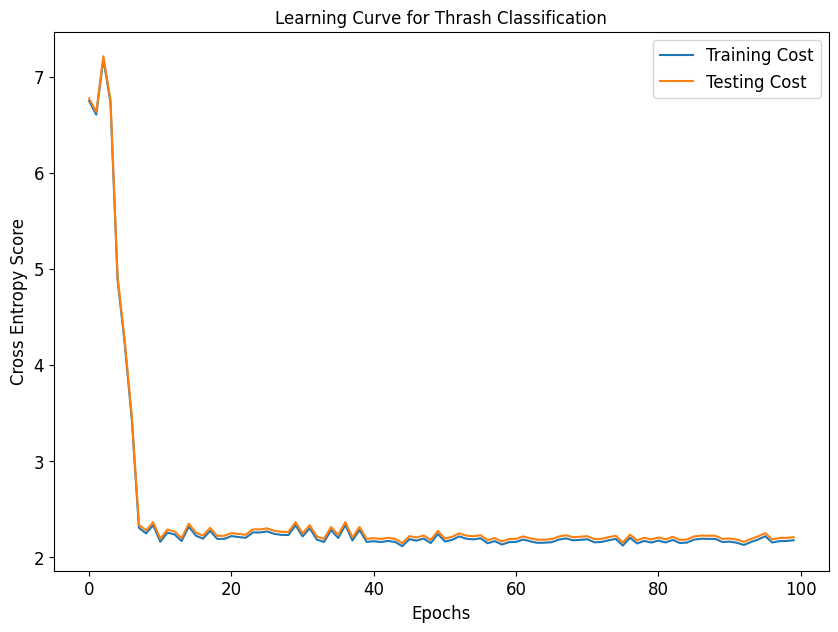

In [20]:
print(f"Final Test Cross Entropy with best parameters: {best_score:.6f} at {best_iteration} epochs")
fig , ax = plt.subplots(figsize=(10,7))
ax.plot(training_scores, label=f'Training Cost')
ax.plot(testing_scores, label=f'Testing Cost ')
ax.set_title(f'Learning Curve for Thrash Classification', fontsize=12)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Cross Entropy Score', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.savefig("Thrash_Learning_Curve.png")
plt.show()

In [ ]:
import Functions as F
import tqdm


X_train_flat = X_train.reshape(X_train.shape[0], -1)
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

start = tqdm.tqdm()
best_score_2, best_iteration_2,best_model_2,training_scores_2,testing_scores_2 = F.run_training_experiment(X_train_flat, y_train_onehot, X_test.reshape(X_test.shape[0], -1), y_test_onehot,
                          n_epochs=10, method="Adam", batch_size=32, learning_rate=0.01,
                             activation_funcs=[F.sigmoid,F.ReLU,F.sigmoid,F.ReLU, F.sigmoid] + [F.softmax], 
                             activation_ders=[F.der_sigmoid,F.der_ReLU,F.der_sigmoid,F.der_ReLU,F.der_sigmoid] + [F.der_softmax], 
                             layer_sizes=[1000,700,700,500,300] + [len(class_names)],
                             cost_func=F.cross_entropy,
                             cost_der_func=F.der_softmax, 
                             Regularization_type="L1", 
                             lambda_reg=1e-4,
                             best_model_iteration=True)
endtime = tqdm.tqdm()
print(f"Total training time: {endtime.start_t - start.start_t:.2f} seconds")

c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\.venv\Lib\site-packages\autograd\tracer.py:54: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [26]:
final_cost = best_model_2.cost(X_test.reshape(X_test.shape[0], -1), y_test_onehot)
print(f"Final Test on Thrash: {final_cost:.6f}")

test_predictions = best_model_2.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

test_predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Final Test Accuracy on Thrash: {accuracy * 100:.2f}%")

Final Test on Thrash: 2.240676
Final Test Accuracy on Thrash: 13.56%
Final Test Accuracy on Thrash: 19.45%


Final Test Cross Entropy with best parameters: 2.144093 at 44 epochs


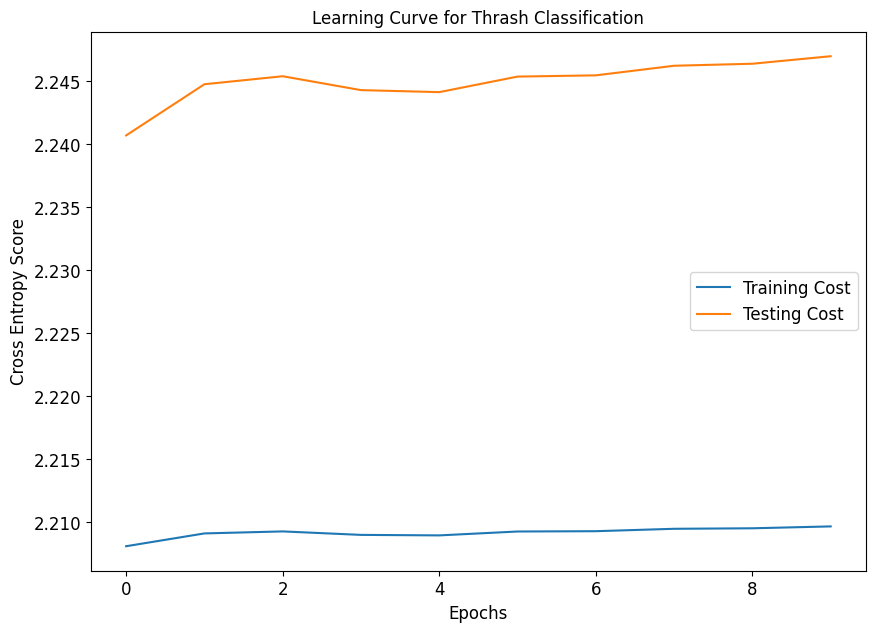

In [25]:
print(f"Final Test Cross Entropy with best parameters: {best_score:.6f} at {best_iteration} epochs")
fig , ax = plt.subplots(figsize=(10,7))
ax.plot(training_scores_2, label=f'Training Cost')
ax.plot(testing_scores_2, label=f'Testing Cost ')
ax.set_title(f'Learning Curve for Thrash Classification', fontsize=12)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Cross Entropy Score', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.savefig("Thrash_Learning_Curve_2.png")
plt.show()

### Testing Keras FFNN

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_ffnn_model(input_shape, num_classes):
    """
    Builds a Feed-Forward Neural Network (Dense layers only).
    """
    model = models.Sequential([
        # FLATTEN LAYER: Critical for FFNN
        # Converts 2D/3D image (e.g., 64x64x3) into a 1D vector (length 12,288)
        layers.Flatten(input_shape=input_shape),

        # HIDDEN LAYER 1
        # High neuron count needed to capture complex patterns from raw pixels
        layers.Dense(1000, activation='sigmoid'),
        #layers.Dropout(0.4), # Drop 40% to prevent memorization
        #1000,700,500,300
        # HIDDEN LAYER 2
        layers.Dense(700, activation='sigmoid'),
        #layers.Dropout(0.3),

        # HIDDEN LAYER 3
        layers.Dense(500, activation='sigmoid'),
        #layers.Dropout(0.2),
        layers.Dense(300, activation='sigmoid'),
        # OUTPUT LAYER
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

2025-12-10 17:10:46.795296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
IMG_SIZE = (128, 128) 
#X_train, X_test, y_train, y_test, class_names = load_realwaste_dataset(
#            data_dir, 
#            img_size=IMG_SIZE,
#            grayscale=False 
#        )

# Get Input Shape (Height, Width, Channels)
# Note: Even though we flatten inside the model, we pass the original shape here.

input_shape = X_train.shape[1:] 
print(f"Building FFNN for input shape: {input_shape}")
# Build Model
model = build_ffnn_model(input_shape, len(class_names))
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#model.summary()
# Train
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

In [13]:
input_shape = X_aug.shape[1:] 
print(f"Building FFNN for input shape: {input_shape}")
# Build Model
model = build_ffnn_model(input_shape, len(class_names))
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#model.summary()
# Train
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True
)
history = model.fit(
    X_aug, y_aug,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

Building FFNN for input shape: (128, 128, 3)


c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlaring\Eget Arbeid\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 322s 441ms/step - accuracy: 0.1814 - loss: 2.1651 - val_accuracy: 0.1945 - val_loss: 2.1527
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 307s 431ms/step - accuracy: 0.1849 - loss: 2.1607 - val_accuracy: 0.1945 - val_loss: 2.1572
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 300s 420ms/step - accuracy: 0.1884 - loss: 2.1592 - val_accuracy: 0.1661 - val_loss: 2.1626
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.1945 - loss: 2.1527

Final Test Accuracy: 19.45%


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 

print("Fitting PCA (this may take a moment)...")
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

print(f"Original Feature Count: {X_train.shape[1]*X_train.shape[2]*X_train.shape[3]}")
print(f"Reduced PCA Feature Count: {X_train_pca.shape[1]}")


input_shape = (X_train_pca.shape[1],) 
print(f"Building FFNN for input shape: {input_shape}")
# Build Model
model = build_ffnn_model(input_shape, len(class_names))
# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#model.summary()
# Train
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True
)
history = model.fit(
    X_train_pca, y_aug,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_pca, y_test),
    callbacks=[early_stopping]
)
# Evaluate
loss, accuracy = model.evaluate(X_test_pca, y_test)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

Fitting PCA (this may take a moment)...
Original Feature Count: 49152
Reduced PCA Feature Count: 962
Building FFNN for input shape: (962,)


c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlaring\Eget Arbeid\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 3801
'y' sizes: 22806


Interesting result, the same as was found in the personal created FFNN from projecct 2 except, this was more efficient in calculation.
I.e. 3 min 30 seconds compared to 4 hours.

Perhaps the struggle is because the optimal parameters was not selected for this Neural network


### Creating more data by roations etc..

### Using the CNN to get better performance
- Better speed?
- Better predictions?

In [ ]:
# Set the path to your RealWaste dataset
data_dir = r'c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\Project Work\Project 3\realwaste-main\RealWaste'

# Load the dataset (RGB version)
X_train, X_test, y_train, y_test, class_names = load_realwaste_dataset(
    data_dir=data_dir,
    img_size=(128, 128),  
    test_size=0.2,
    random_state=42,
    grayscale=False       
)

print("\nDataset loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Loading images from dataset...
Loading 461 images from Cardboard...
Loading 411 images from Food Organics...
Loading 420 images from Glass...
Loading 790 images from Metal...
Loading 495 images from Miscellaneous Trash...
Loading 500 images from Paper...
Loading 921 images from Plastic...
Loading 318 images from Textile Trash...
Loading 436 images from Vegetation...

Dataset loaded:
Total images: 4752
Image shape: (128, 128, 3)
Number of classes: 9

Class distribution:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Train set: 3801 images
Test set: 951 images

Train set class distribution:
  Cardboard: 369 images (9.7%)
  Food Organics: 329 images (8.7%)
  Glass: 336 images (8.8%)
  Metal: 632 images (16.6%)
  Miscellaneous Trash: 396 images (10.4%)
  Paper: 400 images (10.5%)
  Plastic: 736 images (19.4%)
  Textil

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

IMG_HEIGHT, IMG_WIDTH = 128, 128
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = len(class_names)

model = models.Sequential([
        # 1. Input Layer
        layers.Input(shape=input_shape),

        # 2. Data Augmentation (Prevents overfitting on small datasets)
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),

        # 3. Feature Extraction Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 4. Feature Extraction Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 5. Feature Extraction Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 6. Feature Extraction Block 4 (Deeper abstraction)
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 7. Classification Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), # Drops 50% of neurons to prevent overfitting
        layers.Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])

In [8]:
model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # Used when labels are integers (0, 1, 2...), not one-hot
        metrics=['accuracy']
    )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,553 (8.93 MB)

 Trainable params: 2,340,553 (8.93 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 5. Train with Early Stopping
    # Stop training if validation loss doesn't improve for 5 epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 29s 223ms/step - accuracy: 0.2023 - loss: 2.1228 - val_accuracy: 0.2587 - val_loss: 1.9428
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.2741 - loss: 1.9313 - val_accuracy: 0.3754 - val_loss: 1.7661
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.3544 - loss: 1.7513 - val_accuracy: 0.3470 - val_loss: 1.8035
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.4220 - loss: 1.6179 - val_accuracy: 0.4742 - val_loss: 1.4845
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.4304 - loss: 1.5638 - val_accuracy: 0.4690 - val_loss: 1.5016
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - accuracy: 0.4615 - loss: 1.4903 - val_accuracy: 0.4679 - val_loss: 1.5395
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.4859 - loss: 1.4258 - val_accuracy: 0.4911 - val_loss: 1.3893
Epoch 8/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.5059 - loss: 1

In [9]:
# 5. Train with Early Stopping
    # Stop training if validation loss doesn't improve for 5 epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
    X_aug, y_aug,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

Epoch 1/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 130s 179ms/step - accuracy: 0.3582 - loss: 1.7420 - val_accuracy: 0.5394 - val_loss: 1.2764
Epoch 2/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 125s 175ms/step - accuracy: 0.5321 - loss: 1.2949 - val_accuracy: 0.5994 - val_loss: 1.1793
Epoch 3/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 126s 177ms/step - accuracy: 0.5987 - loss: 1.1097 - val_accuracy: 0.5741 - val_loss: 1.1663
Epoch 4/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 126s 176ms/step - accuracy: 0.6365 - loss: 1.0036 - val_accuracy: 0.6814 - val_loss: 0.9264
Epoch 5/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 125s 175ms/step - accuracy: 0.6770 - loss: 0.8941 - val_accuracy: 0.6772 - val_loss: 0.9215
Epoch 6/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 125s 175ms/step - accuracy: 0.7057 - loss: 0.8054 - val_accuracy: 0.7098 - val_loss: 0.8306
Epoch 7/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 126s 177ms/step - accuracy: 0.7227 - loss: 0.7519 - val_accuracy: 0.6982 - val_loss: 0.8302
Epoch 8/30
713/713 ━━━━━━━━━━━━━━━━━━━━ 125s 176ms/step - accuracy: 0.7459 -

#### Grayscale training on this CNN


In [12]:
# Set the path to your RealWaste dataset
data_dir = r'c:\Users\Anton\Documents\UiO Fag\FYS-STK4155 Anvendt dataanalyse og maskinlæring\Eget Arbeid\Project Work\Project 3\realwaste-main\RealWaste'

# Load the dataset (RGB version)
X_train_gray, X_test_gray, y_train_gray, y_test_gray, class_names = load_realwaste_dataset(
    data_dir=data_dir,
    img_size=(128, 128),  
    test_size=0.2,        
    random_state=42,
    grayscale=True       
)

print("\nDataset loaded successfully!")
print(f"Training set shape: {X_train_gray.shape}")
print(f"Test set shape: {X_test_gray.shape}")

X_train = np.expand_dims(X_train_gray, axis=-1)
X_test = np.expand_dims(X_test_gray, axis=-1)
input_shape = (128, 128, 1)

model = models.Sequential([
        # 1. Input Layer
        layers.Input(shape=input_shape),

        # 2. Data Augmentation (Prevents overfitting on small datasets)
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),

        # 3. Feature Extraction Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 4. Feature Extraction Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 5. Feature Extraction Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 6. Feature Extraction Block 4 (Deeper abstraction)
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 7. Classification Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5), # Drops 50% of neurons to prevent overfitting
        layers.Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])
model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # Used when labels are integers (0, 1, 2...), not one-hot
        metrics=['accuracy']
    )

# 5. Train with Early Stopping
    # Stop training if validation loss doesn't improve for 5 epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
    X_train_gray, y_train_gray,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_gray, y_test_gray),
    callbacks=[early_stopping]
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(X_test_gray, y_test_gray)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

Loading images from dataset...
Loading 461 images from Cardboard...
Loading 411 images from Food Organics...
Loading 420 images from Glass...
Loading 790 images from Metal...
Loading 495 images from Miscellaneous Trash...
Loading 500 images from Paper...
Loading 921 images from Plastic...
Loading 318 images from Textile Trash...
Loading 436 images from Vegetation...

Dataset loaded:
Total images: 4752
Image shape: (128, 128)
Number of classes: 9

Class distribution:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Train set: 3801 images
Test set: 951 images

Train set class distribution:
  Cardboard: 369 images (9.7%)
  Food Organics: 329 images (8.7%)
  Glass: 336 images (8.8%)
  Metal: 632 images (16.6%)
  Miscellaneous Trash: 396 images (10.4%)
  Paper: 400 images (10.5%)
  Plastic: 736 images (19.4%)
  Textile T

Grayscale had a test accuracy of 55 % towards the 60 % generated from the full RGB images i.e. there is hope in seeing the distinctions more in terms of the shapes of the objects rather than the color of them.
Also with a 128x128 pixelated image

### Doing the hyperscales 

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix
import os
data_dir = r'.\realwaste-main\RealWaste'


def build_model(hp):
    """
    This function defines the search space for Keras Tuner.
    """
    model = models.Sequential()
    
    # We can tune the input size logic if needed, but usually we tune the network
    # Assuming input is flattened
    model.add(layers.Flatten(input_shape=(64, 64, 3)))
    
    # Tune the number of hidden layers (between 1 and 4)
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(
            # Tune number of units per layer
            units=hp.Int(f'units_{i}', min_value=64, max_value=1024, step=64),
            activation='relu'
        ))
        # Tune dropout rate
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))
    
    model.add(layers.Dense(9, activation='softmax'))
    
    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [6]:
X_train, X_test, y_train, y_test, class_names = load_realwaste_dataset(
    data_dir, 
    img_size=(64,64),
    test_size=0.2,
    grayscale=False    
)

Loading images from dataset...
Loading 461 images from Cardboard...
Loading 411 images from Food Organics...
Loading 420 images from Glass...
Loading 790 images from Metal...
Loading 495 images from Miscellaneous Trash...
Loading 500 images from Paper...
Loading 921 images from Plastic...
Loading 318 images from Textile Trash...
Loading 436 images from Vegetation...

Dataset loaded:
Total images: 4752
Image shape: (64, 64, 3)
Number of classes: 9

Class distribution:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Train set: 3801 images
Test set: 951 images

Train set class distribution:
  Cardboard: 369 images (9.7%)
  Food Organics: 329 images (8.7%)
  Glass: 336 images (8.8%)
  Metal: 632 images (16.6%)
  Miscellaneous Trash: 396 images (10.4%)
  Paper: 400 images (10.5%)
  Plastic: 736 images (19.4%)
  Textile 

In [7]:
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix
import os

tuner = kt.RandomSearch(
    build_model, #takes 64x64 images to reduce computation
    objective='val_accuracy',
    max_trials=10,  # Try 10 different model combinations
    executions_per_trial=1,
    directory='tuner_results',
    project_name='waste_classification',
    overwrite=True
)

tuner.search_space_summary()

print("\nStarting Hyperparameter Search...")
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nOptimal Learning Rate: {best_hps.get('learning_rate')}")
print(f"Optimal Layers: {best_hps.get('num_layers')}")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model fully
print("\nTraining best model fully...")
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# Evaluate
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")
        

Trial 10 Complete [00h 01m 24s]
val_accuracy: 0.20236530900001526

Best val_accuracy So Far: 0.3035479485988617
Total elapsed time: 00h 08m 46s

Optimal Learning Rate: 0.001
Optimal Layers: 2

Training best model fully...
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.1447 - loss: 4.4502 - val_accuracy: 0.2339 - val_loss: 2.1804
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.1556 - loss: 2.1876 - val_accuracy: 0.2273 - val_loss: 2.1432
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.1865 - loss: 2.1442 - val_accuracy: 0.2510 - val_loss: 2.0949
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.2072 - loss: 2.1301 - val_accuracy: 0.2050 - val_loss: 2.0870
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.2141 - loss: 2.1065 - val_accuracy: 0.2286 - val_loss: 2.0584
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.2181 - loss: 2.0820 - val_accuracy: 0.2536 - val_loss: 2.0636
Epoc

### Doing it for the CNN

In [4]:
def build_cnn_model(hp):
    """
    Defines the CNN search space based on your successful baseline.
    """
    input_shape = (128, 128, 3)
    num_classes = 9 # RealWaste has 9 classes

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # --- Data Augmentation ---
    # We keep this fixed as it's standard practice
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.1))

    # --- Convolutional Blocks ---
    
    # Block 1: Tune filters (Baseline: 32)
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=64, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: Tune filters (Baseline: 64)
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: Tune filters (Baseline: 128)
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: Deep abstraction (Baseline: 128)
    # Sometimes removing the 4th block helps, or making it deeper
    if hp.Boolean('use_block_4', default=True):
        model.add(layers.Conv2D(
            filters=hp.Int('conv_4_filters', min_value=128, max_value=256, step=64),
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2)))

    # --- Classification Head ---
    model.add(layers.Flatten())
    
    # Dense Layer: Tune units (Baseline: 256)
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu'
    ))
    
    # Dropout: Tune rate (Baseline: 0.5)
    model.add(layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)
    ))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    # --- Compilation ---
    learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3, 5e-4, 1e-4])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:

import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 8))

    cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(cax)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)
    
    # Text annotations loop
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks


tuner = kt.RandomSearch(
            build_cnn_model,
            objective='val_accuracy',
            max_trials=10,  # Try 10 combinations
            executions_per_trial=1,
            directory='tuner_results', 
            project_name='waste_cnn_tuning'
        )
        
tuner.search_space_summary()

print("\nStarting CNN Hyperparameter Search...")
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Best Hyperparameters Found ---")
print(f"Conv 1 Filters: {best_hps.get('conv_1_filters')}")
print(f"Conv 2 Filters: {best_hps.get('conv_2_filters')}")
print(f"Conv 3 Filters: {best_hps.get('conv_3_filters')}")
print(f"Use Block 4: {best_hps.get('use_block_4')}")
if best_hps.get('use_block_4'):
    print(f"Conv 4 Filters: {best_hps.get('conv_4_filters')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model fully
print("\nTraining best model fully...")
history = best_model.fit(X_train, y_train, epochs=25, validation_split=0.2)

# Evaluate
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Visualization
y_pred = np.argmax(best_model.predict(X_test), axis=1)
class_names = ['Cardboard', 'Food', 'Glass', 'Metal', 'Misc', 'Paper', 'Plastic', 'Textile', 'Veg']
plot_confusion_matrix(y_test, y_pred, class_names)

Trial 5 Complete [00h 05m 00s]
val_accuracy: 0.20236530900001526

Best val_accuracy So Far: 0.20236530900001526
Total elapsed time: 00h 20m 47s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filters
128               |96                |conv_2_filters
256               |192               |conv_3_filters
False             |False             |use_block_4
192               |128               |conv_4_filters
192               |192               |dense_units
0.5               |0.3               |dropout_rate
0.1               |0.01              |learning_rate

Epoch 1/10
53/95 ━━━━━━━━━━━━━━━━━━━━ 26s 627ms/step - accuracy: 0.1609 - loss: 286062.4602

KeyboardInterrupt: 

In [ ]:
def build_cnn_model(hp):
    """
    Defines the CNN search space based on your successful baseline.
    Now includes Optimizer, Activation, and Kernel Size tuning.
    """
    input_shape = (128, 128, 3)
    num_classes = 9 # RealWaste has 9 classes

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # --- Data Augmentation ---
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.1))

    # --- Shared Hyperparameters ---
    # Try different activation functions (ReLU vs ELU)
    # ELU (Exponential Linear Unit) can sometimes speed up learning
    activation_choice = hp.Choice('activation', values=['relu', 'elu'])

    # --- Convolutional Blocks ---
    
    # Block 1: Tune filters AND Kernel Size
    # A larger kernel (5x5) in the first layer can capture broader features
    kernel_size_1 = hp.Choice('conv_1_kernel', values=[3, 5])
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=64, step=32),
        kernel_size=(kernel_size_1, kernel_size_1),
        padding='same',
        activation=activation_choice
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: Tune filters
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation=activation_choice
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: Tune filters
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same',
        activation=activation_choice
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: Deep abstraction
    if hp.Boolean('use_block_4', default=True):
        model.add(layers.Conv2D(
            filters=hp.Int('conv_4_filters', min_value=128, max_value=256, step=64),
            kernel_size=(3, 3),
            padding='same',
            activation=activation_choice
        ))
        model.add(layers.MaxPooling2D((2, 2)))

    # --- Classification Head ---
    model.add(layers.Flatten())
    
    # Dense Layer: Tune units
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation=activation_choice
    ))
    

    if hp.Boolean('extra_dense_layer'):
        # Add a dropout before the second dense layer to prevent overfitting
        model.add(layers.Dropout(0.25)) 
        model.add(layers.Dense(
            units=hp.Int('dense_units_2', min_value=64, max_value=256, step=32),
            activation=activation_choice
        ))

    # Dropout: Tune rate
    model.add(layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)
    ))
    
    model.add(layers.Dense(num_classes, activation='softmax'))



    # --- Compilation ---
    # Tune Optimizer (Adam vs SGD) and Learning Rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    if optimizer_choice == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        # SGD often generalizes better but trains slower; momentum helps
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model   

Trial 10 Complete [00h 04m 49s]
val_accuracy: 0.42444151639938354

Best val_accuracy So Far: 0.546649158000946
Total elapsed time: 00h 59m 55s

--- Best Hyperparameters Found ---
Conv 1 Filters: 32
Conv 2 Filters: 128
Conv 3 Filters: 128
Use Block 4: True
Conv 4 Filters: 192
Dense Units: 320
Dropout Rate: 0.3
Learning Rate: 0.0005

Training best model fully...
Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 306ms/step - accuracy: 0.3089 - loss: 1.9230 - val_accuracy: 0.4021 - val_loss: 1.7457
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - accuracy: 0.4062 - loss: 1.6470 - val_accuracy: 0.4297 - val_loss: 1.6442
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 316ms/step - accuracy: 0.4405 - loss: 1.5454 - val_accuracy: 0.3417 - val_loss: 2.1035
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - accuracy: 0.4730 - loss: 1.4579 - val_accuracy: 0.4323 - val_loss: 1.6340
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 30s 314ms/step - accuracy: 0.5059 - loss: 1.3756 - val_accuracy: 0.4849 - val_loss:

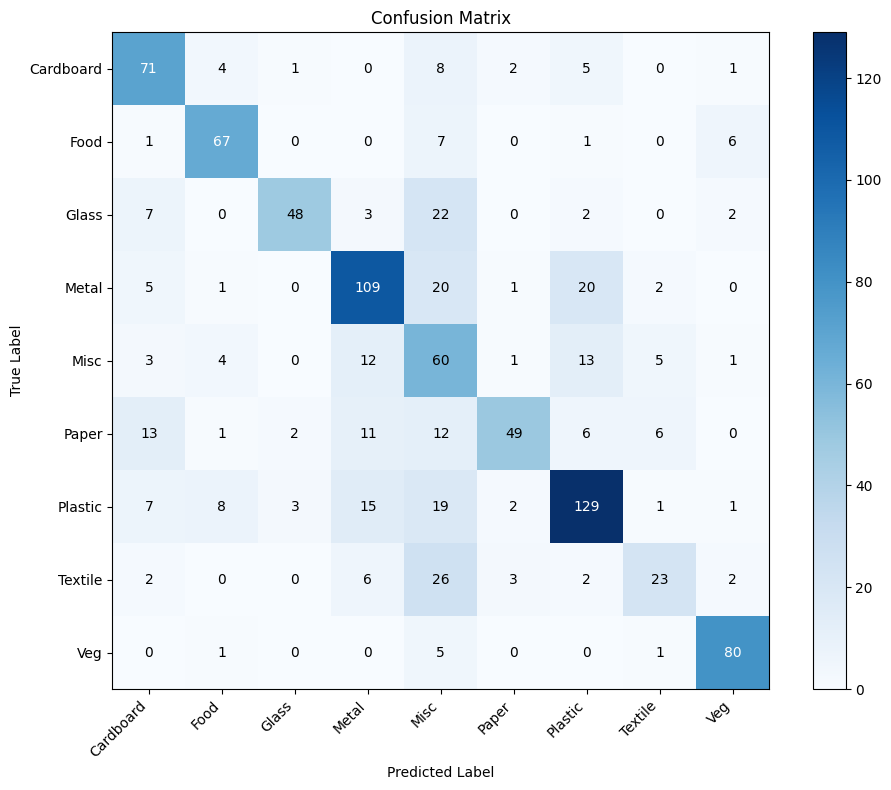

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks


tuner = kt.RandomSearch(
            build_cnn_model,
            objective='val_accuracy',
            max_trials=10,  # Try 10 combinations
            executions_per_trial=1,
            directory='tuner_results', 
            project_name='more_cnn_tuning'
        )
        
tuner.search_space_summary()

print("\nStarting CNN Hyperparameter Search...")
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Best Hyperparameters Found ---")
print(f"Activation Function: {best_hps.get('activation')}")
print(f"Conv 1 Filters: {best_hps.get('conv_1_filters')}")
print(f"Conv 2 Filters: {best_hps.get('conv_2_filters')}")
print(f"Conv 3 Filters: {best_hps.get('conv_3_filters')}")
print(f"Use Block 4: {best_hps.get('use_block_4')}")
if best_hps.get('use_block_4'):
    print(f"Conv 4 Filters: {best_hps.get('conv_4_filters')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model fully
print("\nTraining best model fully...")
history = best_model.fit(X_train, y_train, epochs=25, validation_split=0.2)

# Evaluate
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Visualization
y_pred = np.argmax(best_model.predict(X_test), axis=1)
class_names = ['Cardboard', 'Food', 'Glass', 'Metal', 'Misc', 'Paper', 'Plastic', 'Textile', 'Veg']
plot_confusion_matrix(y_test, y_pred, class_names)

### Utilizing these parameters on higher quality pixels



In [19]:
# Set the path to your RealWaste dataset
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

# Load the dataset (RGB version)
BATCH_SIZE = 32
IMG_SIZE = (512, 512) # High resolution is now safe to use
SEED = 42
data_dir = r'.\realwaste-main\RealWaste'

print("Setting up data pipeline...")



class_folders = [
        'Cardboard', 'Food Organics', 'Glass', 'Metal', 
         'Paper', 'Plastic', 
        'Textile Trash', 'Vegetation'
    ]

# ==========================================
# 2. DATA PIPELINE (The "Streaming" Solution)
# ==========================================

# A. Load the Training Data (80% of total)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   # Reserve 20% for Val/Test
    subset="training",
    seed=SEED,              # Fixed seed prevents overlap
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    class_names=class_folders
    )

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes found: {class_names}")

# B. Load the Remaining Data (20% of total)
val_and_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,              # Must match seed above!
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    class_names=class_folders
)

# C. Split the Remaining 20% into Validation (10%) and Test (10%)
val_batches = tf.data.experimental.cardinality(val_and_test_ds)
test_ds = val_and_test_ds.take(val_batches // 2)
val_ds = val_and_test_ds.skip(val_batches // 2)

print(f"Training Batches:   {tf.data.experimental.cardinality(train_ds)}")
print(f"Validation Batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Test Batches:       {tf.data.experimental.cardinality(test_ds)}")

# D. Performance Optimization
# 'cache' keeps images in memory if possible, 'prefetch' prepares next batch while GPU works
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Get class names for later
print("\nData pipeline setup complete!")
print("\nDataset loaded successfully!")
print(f"Training set shape: {tf.data.experimental.cardinality(train_ds)}")
print(f"Test set shape: {tf.data.experimental.cardinality(test_ds)}")

input_shape = IMG_SIZE + (3,)

model = models.Sequential([
        # 1. Input Layer
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),

        # 2. Data Augmentation (Prevents overfitting on small datasets)
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),

        # 3. Feature Extraction Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 4. Feature Extraction Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 5. Feature Extraction Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # 6. Feature Extraction Block 4 (Deeper abstraction)
        layers.Conv2D(192, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # 7. Classification Head
        layers.Flatten(),
        layers.Dense(320, activation='relu'),
        layers.Dropout(0.3), 
        layers.Dense(num_classes, activation='softmax') # Softmax for multi-class classification
    ])

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
        optimizer=custom_optimizer,
        loss='sparse_categorical_crossentropy', # Used when labels are integers (0, 1, 2...), not one-hot
        metrics=['accuracy']
    )

# 5. Train with Early Stopping
    # Stop training if validation loss doesn't improve for 5 epochs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

# 6. Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Test Accuracy was 60 % at 256x256 resolution


Setting up data pipeline...
Found 4257 files belonging to 8 classes.
Using 3406 files for training.
Classes found: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Found 4257 files belonging to 8 classes.
Using 851 files for validation.
Training Batches:   107
Validation Batches: 14
Test Batches:       13

Data pipeline setup complete!

Dataset loaded successfully!
Training set shape: 107
Test set shape: 13
Epoch 1/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 742s 7s/step - accuracy: 0.2857 - loss: 1.9404 - val_accuracy: 0.3540 - val_loss: 1.7270
Epoch 2/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 779s 7s/step - accuracy: 0.4433 - loss: 1.4964 - val_accuracy: 0.5218 - val_loss: 1.3160
Epoch 3/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 2565s 24s/step - accuracy: 0.5147 - loss: 1.3156 - val_accuracy: 0.4483 - val_loss: 1.5609
Epoch 4/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 949s 9s/step - accuracy: 0.5652 - loss: 1.1741 - val_accuracy: 0.5471 - val_loss: 1.3955
Epoch 5/40
107/107 ━

### Testing with higher resolution 512x512

In [ ]:
def build_cnn_model(hp):
    """
    Defines the CNN search space based on your successful baseline.
    Now includes Optimizer, Activation, and Kernel Size tuning.
    """
    input_shape = (512, 512, 3)
    num_classes = 9 # RealWaste has 9 classes

    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    # --- Data Augmentation ---
    model.add(layers.RandomFlip("horizontal_and_vertical"))
    model.add(layers.RandomRotation(0.2))
    model.add(layers.RandomZoom(0.1))

    # --- Shared Hyperparameters ---
    # Try different activation functions (ReLU vs ELU)
    # ELU (Exponential Linear Unit) can sometimes speed up learning
    activation_choice = hp.Choice('activation', values=['relu', 'elu'])

    # --- Convolutional Blocks ---
    
    # Block 1: Tune filters AND Kernel Size
    # A larger kernel (5x5) in the first layer can capture broader features
    kernel_size_1 = hp.Choice('conv_1_kernel', values=[3, 5])
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=64, step=32),
        kernel_size=(kernel_size_1, kernel_size_1),
        padding='same',
        activation=activation_choice
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 2: Tune filters
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        activation=activation_choice
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 3: Tune filters
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same',
        activation=activation_choice
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Block 4: Deep abstraction
    if hp.Boolean('use_block_4', default=True):
        model.add(layers.Conv2D(
            filters=hp.Int('conv_4_filters', min_value=128, max_value=256, step=64),
            kernel_size=(3, 3),
            padding='same',
            activation=activation_choice
        ))
        model.add(layers.MaxPooling2D((2, 2)))

    # --- Classification Head ---
    model.add(layers.Flatten())
    
    # Dense Layer: Tune units
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation=activation_choice
    ))
    

    if hp.Boolean('extra_dense_layer'):
        # Add a dropout before the second dense layer to prevent overfitting
        model.add(layers.Dropout(0.25)) 
        model.add(layers.Dense(
            units=hp.Int('dense_units_2', min_value=64, max_value=256, step=32),
            activation=activation_choice
        ))

    # Dropout: Tune rate
    model.add(layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)
    ))
    
    model.add(layers.Dense(num_classes, activation='softmax'))



    # --- Compilation ---
    # Tune Optimizer (Adam vs SGD) and Learning Rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    
    if optimizer_choice == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        # SGD often generalizes better but trains slower; momentum helps
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks

X_train, X_test, y_train, y_test = load_realwaste_dataset(
    data_dir, 
    img_size=(512,512),
    test_size=0.2,
    grayscale=False    
)


tuner = kt.RandomSearch(
            build_cnn_model,
            objective='val_accuracy',
            max_trials=10,  # Try 10 combinations
            executions_per_trial=1,
            directory='tuner_results', 
            project_name='more_cnn_tuning'
        )
        
tuner.search_space_summary()

print("\nStarting CNN Hyperparameter Search...")
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n--- Best Hyperparameters Found ---")
print(f"Activation Function: {best_hps.get('activation')}")
print(f"Conv 1 Filters: {best_hps.get('conv_1_filters')}")
print(f"Conv 2 Filters: {best_hps.get('conv_2_filters')}")
print(f"Conv 3 Filters: {best_hps.get('conv_3_filters')}")
print(f"Use Block 4: {best_hps.get('use_block_4')}")
if best_hps.get('use_block_4'):
    print(f"Conv 4 Filters: {best_hps.get('conv_4_filters')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)

# Train the best model fully
print("\nTraining best model fully...")
history = best_model.fit(X_train, y_train, epochs=25, validation_split=0.2)

# Evaluate
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Visualization
y_pred = np.argmax(best_model.predict(X_test), axis=1)
class_names = ['Cardboard', 'Food', 'Glass', 'Metal', 'Misc', 'Paper', 'Plastic', 'Textile', 'Veg']
plot_confusion_matrix(y_test, y_pred, class_names)

### Transfere learning


In [12]:

X_train, X_test, y_train, y_test, class_names = load_realwaste_dataset(
    data_dir, 
    img_size=(128,128),
    test_size=0.2,
    grayscale=False    
)

Loading images from dataset...
Loading 461 images from Cardboard...
Loading 411 images from Food Organics...
Loading 420 images from Glass...
Loading 790 images from Metal...
Loading 495 images from Miscellaneous Trash...
Loading 500 images from Paper...
Loading 921 images from Plastic...
Loading 318 images from Textile Trash...
Loading 436 images from Vegetation...

Dataset loaded:
Total images: 4752
Image shape: (128, 128, 3)
Number of classes: 9

Class distribution:
  Cardboard: 461 images
  Food Organics: 411 images
  Glass: 420 images
  Metal: 790 images
  Miscellaneous Trash: 495 images
  Paper: 500 images
  Plastic: 921 images
  Textile Trash: 318 images
  Vegetation: 436 images

Train set: 3801 images
Test set: 951 images

Train set class distribution:
  Cardboard: 369 images (9.7%)
  Food Organics: 329 images (8.7%)
  Glass: 336 images (8.8%)
  Metal: 632 images (16.6%)
  Miscellaneous Trash: 396 images (10.4%)
  Paper: 400 images (10.5%)
  Plastic: 736 images (19.4%)
  Textil

In [15]:
print("Preprocessing data for MobileNetV2...")
X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X_train)
X_test = tf.keras.applications.mobilenet_v2.preprocess_input(X_test)

# 3. Define Base Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3), # <--- CHANGED from 160 to 128 to match data
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = True

# 4. Build Final Model
model = tf.keras.Sequential([
    base_model,
    
    # Aggregates the features from 4x4x1280 to 1x1280
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    
    # Stabilizes training, allowing the model to learn faster
    layers.BatchNormalization(),
    
    # Shuts off 40% of neurons randomly to force the model to be robust
    layers.Dropout(0.4),
    
    # 6. Output Layer
    layers.Dense(num_classes, activation='softmax')
])

# 5. Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Low rate for transfer learning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 6. Train
# Using X_test as validation here since we are doing a simple 2-way split
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test) 
)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Visualization
y_pred = np.argmax(model.predict(X_test), axis=1)
class_names = ['Cardboard', 'Food', 'Glass', 'Metal', 'Misc', 'Paper', 'Plastic', 'Textile', 'Veg']
plot_confusion_matrix(y_test, y_pred, class_names)

Preprocessing data for MobileNetV2...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,583,049 (13.67 MB)

 Trainable params: 3,546,889 (13.53 MB)

 Non-trainable params: 36,160 (141.25 KB)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 114s 808ms/step - accuracy: 0.1350 - loss: 2.2974 - val_accuracy: 0.1945 - val_loss: 2.4558
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 92s 771ms/step - accuracy: 0.1552 - loss: 2.2240 - val_accuracy: 0.0967 - val_loss: 3.5625
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 94s 792ms/step - accuracy: 0.1994 - loss: 2.1284 - val_accuracy: 0.0967 - val_loss: 6.0476
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 92s 777ms/step - accuracy: 0.2034 - loss: 2.1032 - val_accuracy: 0.0967 - val_loss: 13.7852
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 90s 753ms/step - accuracy: 0.2534 - loss: 2.0297 - val_accuracy: 0.1052 - val_loss: 22.3482
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 89s 749ms/step - accuracy: 0.2715 - loss: 1.9748 - val_accuracy: 0.0967 - val_loss: 37.1513
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 91s 765ms/step - accuracy: 0.2894 - loss: 1.9392 - val_accuracy: 0.1052 - val_loss: 57.8583
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 92s 772ms/step - accuracy: 0.2949 - lo

KeyboardInterrupt: 